
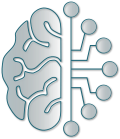

**Début à:** Sunday 03 December 2023, 15:11:26  
**Hostname:** ip-sw-install-nico.insa-toulouse.fr (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/logoDebut.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID as vID
from visualID import color
vID.init(cwd0)

# Traitement statistique de données<br>(data science pour débutants)<br><br>*Statistical treatment of data<br>(data science for beginners)*

## Apprentissage supervisé (*supervised Machine Learning*) appliqué à la classification<br>(régression logistique)<br><br>Supervised Machine Learning applied to classification<br>Logistic regression

<div class="rq">

<b style='color:red'>Ce thème n'est pas si complexe, mais l'analyse du code est réservée aux plus curieu(ses)(x) et motivé(e)s.</b>
<br>Il a pour objectif de montrer qu'il est possible de prédire une valeur sur la base d'une corrélation multifactorielle entre une <b>classe d'objets</b> (ici des espèces d'iris) et des <b>propriétés</b> (ou descripteurs, ici les largeurs et longueurs des pétales et des sépales) 
<br><b style='color:red'>Les moins curieu(ses)(x) doivent <i>a minima</i> lire les commentaires et exécuter ce code pour en comprendre le principe.</b>
</div>

<div class="rqE">

<b style='color:red'>This topic is not so complex, but the analysis of the code is reserved for the most curious and motivated.</b><br>
It aims at showing that it is possible to predict a value based on a multifactorial correlation between a <b>class of objects</b> (here iris species) and <b>properties</b> (or descriptors, here widths and lengths of petals and sepals)<br>
<b style='color:red'>The less curious should at least read the comments and execute this code to understand the principle.</b>
</div>

### Introduction

#### Objectif et principe général<br>*Goal and general objective*

<div class="intro">

On a vu dans la partie précédente (statistiques et régression) qu'il est possible de prédire une valeur ($\hat{y}$) sur la base d'une régression, c'est-à-dire du *fit* d'une fonction mathématique qui relie deux variables entre elles ($y$ et $x$). On a pour cela utilisé les outils de régression offerts par le module `SciPy`. On a pu ainsi prédire la longueur d'un pétale d'iris, connaissant sa largeur, compte tenu de la relation linéaire entre longueur et largeur.

On a également constaté dans la première partie que la distribution jointe des caractéristiques longueurs et largeurs des pétales (`jointplot`) est presque suffisante pour classifier les 3 espèce d'iris (figure de gauche). La zone de recouvrement entre caractéristiques de pétales des espèces <i>versicolor</i> et <i>virginica</i> ne permet malheureusement pas de trancher entre grands iris <i>versicolor</i> et petits iris <i>virginica</i>. On voit sur la figure de droite que les sépales des iris <i>setosa</i> ont des dimensions différentes des deux autres, alors que <i>versicolor</i> et <i>virginica</i> ont pour la plupart des sépales de dimensions similaires.
</div>

<div class="introE">

We saw in the previous section (statistics and regression) that it is possible to predict a value ($\hat{y}$) on the basis of a regression, *i.e.* the fit of a mathematical function that links two variables together ($y$ and $x$). This was done using the regression tools offered by the `SciPy` library. This allowed us to predict the length of an iris petal, knowing its width, given the linear relationship between length and width.

It was also found in the first part that the joint distribution of petal length and width features (`jointplot`) is almost sufficient to classify the 3 iris species (left figure). The overlapping area between petal characteristics of *versicolor* and *virginica* species does not allow to decide between large *versicolor* iris and small *virginica* iris. The figure on the right shows that the sepals of the *setosa* iris have different dimensions from the other two, while *versicolor* and *virginica* have mostly similar sized sepals
<p style="text-align: center"><img width="900px" src="DS4B-svg/jointplot_petals-sepals_classification.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></img></p>

</div>

<div class="rq">

Le premier objectif de ce TP est d'entraîner un modèle d'Intelligence Artificielle (IA) à <span style="color:red"><b>classifier</b></span> les espèces d'iris sur la base des <span style="color:red">longueurs (L<sub>P</sub>) et largeurs (&ell;<sub>P</sub>) de leurs pétales</span>. L'architecture est la suivante :
</div>
<div class="rqE">
The first objective of this lab is to train an Artificial Intelligence (AI) model to <span style="color:red"><b>classify</b></span> iris species based on the <span style="color:red">lengths (L<sub>P</sub>) and widths (&ell;<sub>P</sub>) of their petals</span>. The architecture is as follows:   
    
<p><img width="350px" src="DS4B-svg/AI-petals.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_AI_jpc"/></p>  
    
</div>
<div class="rq">

C'est-à-dire qu'on va spécifier 2 paramètres en entrée, et qu'on veut obtenir en sortie les probabilités <i>P</i> que l'espèce d'iris caractérisée par ces deux propriétés soit de la famille <i>setosa</i>, <i>versicolor</i> ou <i>virginica</i>.
</div>
<div class="rqE">
    
That is to say that we will specify 2 parameters in input, and that we want to obtain in output the probabilities P that the species of iris characterized by these two properties is of the family *setosa*, *versicolor* or *virginica*.
</div>

<div class="intro">

Il faut d'abord entraîner un modèle à faire un lien entre les 2 caractéristiques de pétales d'une part et espèce d'iris d'autre part. On parle d'<b>apprentissage supervisé</b> (<b><i>supervised machine learning</b></i>). Il existe plusieurs modèles statistiques qui peuvent faire ce type d'apprentissage visant à classifier des individus : arbres de décision, séparateurs à vaste marge (<i>support-vector machine</i>, SVM), réseaux de neurones artificiels (<i>artificial neural network</i>, ANN)... Même si ce n'est pas le plus approprié pour un problème aussi simple que celui-ci, on va utiliser une méthode d'apprentissage profond (<i>deep learning</i>), qui est un réseau de neurones particulier. On va découvrir que mettre au point un modèle de ce type n'est en réalité pas si compliqué que ça.

Voici à quoi ressemble dans ce cas précis une boîte noire exploitant le deep learning : 

<p style="text-align: center"><img width="250px" src="DS4B-svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"/></p>

Elle est constituée de neurones artificiels tous connectés entre eux : (a) deux neurones d'entrée qui vont recevoir pour chaque espèce les largeurs et longueurs des pétales; (b) trois neurones de sortie qui vont contenir la probabilité pour que l'iris de cette taille soit <i>setosa</i> (P<sub>1</sub>), <i>versicolor</i> (P<sub>2</sub>) ou <i>virginica</i> (P<sub>3</sub>); (c) deux couches intermédiaires de neurones. Ces couches intermédiaires sont appelées couches cachées. On parle de <b>deep learning</b> pour tout ANN qui contient un mlinimum de deux couches cachées.

Un <b>neurone artificiel</b> est en général caractérisé par
<li> les <b>poids</b> des connexions qui le relie aux autres neurones, c'est-à-dire l'équivalent des poids synaptiques
<li> son "mode de fonctionnement", on parle de <b>fonction d'activation</b>
<li> une constante (le <b>biais</b>) qui aide le modèle (l'IA) à s’adapter au mieux aux données du problème
</div>

<div class="introE">

First, a model must be trained to make a link between the 2 characteristics of petals on the one hand and iris species on the other hand. This is called **supervised machine learning**. There are several statistical models that can do this type of learning to classify individuals: decision trees, support-vector machines (SVM), artificial neural networks (ANN)... Even if it is not the most appropriate for a problem as simple as this one, we will use a deep learning method, which is a particular neural network. We will discover that developing such a model is actually not that complicated.

Here is what a black box using deep learning looks like in this case:
    
<p style="text-align: center"><img width="250px" src="DS4B-svg/ANN-petals.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpcE"/></p>

It consists of artificial neurons all connected to each other: (a) two input neurons that will receive for each species the widths and lengths of the petals; (b) three output neurons that will contain the probability that the iris of this size is *setosa* (P<sub>1</sub>), *versicolor* (P<sub>2</sub>) or *virginica* (P<sub>3</sub>); (c) two intermediate layers of neurons. These intermediate layers are called hidden layers. We speak of deep learning for any ANN that contains a minimum of two hidden layers.

An **artificial neuron** is generally characterized by

- the **weights** of the connections that link it to other neurons, *i.e.* the equivalent of synaptic weights
- its "mode of operation", *i.e.* an **activation function**
- a constant (the **bias**) that helps the model (the AI) to adapt to the problem data
</div>

#### Importation des modules utiles<br>*Importation of the useful libraries*

<div class="intro">

Outre `pandas`, les deux bibliothèques majeures sont `TensorFlow` et `Keras`. On utilisera également un peu plus tard des utilitaires fournis par le module `scikit learn`.</div>
  
<div class="introE">

Besides `pandas`, the two major libraries are `TensorFlow` and `Keras`. Later on, we will also use utilities provided by the `scikit learn` module.
<p style="text-align: center"><img width="300px" src="DS4B-svg/logos-TFKSKL.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_logos"/></p>

</div>

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
#from keras.utils import np_utils

2023-12-03 15:11:34.950608: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 15:11:34.978898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 15:11:35.112074: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 15:11:35.113025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 15:11:35.988704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Préparation des données<br>*Data preparation*

#### Lecture de la base de données qui ont été adaptées au problème<br>*Reading of the database, adapted for the current application*

<div class="intro">

Les données brutes sont en général mal adaptées aux algorithmes d'apprentissage automatique. La/le *data scientist* doit faire en amont un travail de transformation de ces données. On a ici appliqué au préalable un "encodage 1 parmi n" (ou *one-hot-encoding*) des espèces d'iris (les plus curieu(x)(ses) peuvent se référer à l'annexe). On va lire la nouvelle base de données (nommée `iris_ohe.csv`) afin de plus facilement comprendre en quoi consiste cet encodage.</div>

<div class="introE">

Raw data is generally not well adapted to machine learning algorithms. The data scientist has to transform the data beforehand. We have applied here a one-hot-encoding of the iris species (the most curious can refer to the appendix). We will read the new database (named `iris_ohe.csv`) in order to understand more easily what this encoding consists in.</div>

In [5]:
dfi=pd.read_csv('./DS4B-iris-data/iris_ohe.csv', sep="\t") #columns are separated with the tabulation ('tab') character
print(f"Dfi. Structure (shape) :{dfi.shape}")
display(dfi)

Dfi. Structure (shape) :(150, 8)


,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,setosa,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,setosa,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,setosa,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,setosa,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,virginica,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,virginica,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,virginica,0.0,0.0,1.0


<div class="rq">


Le nouveau ficher de données contient 3 nouvelles colonnes (*setosa*, *versicolor*, *virginica*), qui ne contient que des 0 ou des 1, qui ne sont rien d'autre que les probabilités que chacune des fleurs d'iris soit setosa, versicolor ou virginica. Comme c'est un botaniste qui a établi de façon sûre la classification de cette base de données, les probabilités ne peuvent valoir que 0 ou 1 (et bien entendu il ne peut y avoir qu'une seule valeur '1.0' par ligne). 
    
</div>

<div class="rqE">

The new data file contains 3 new columns (*setosa*, *versicolor*, *virginica*), which contain only 0's or 1's, which are nothing but the probabilities that each iris flower is *setosa*, *versicolor* or *virginica*. As a botanist has reliably established the classification of this database, the probabilities can only be 0 or 1 (and of course there can only be one value '1.0' per line).
</div>

#### Séparation des données en deux sous-ensembles d'apprentissage et de test<br>Separation of data between training and test

<div class="intro">  
On est au c&oelig;ur de l'apprentissage automatique :
    <li> les algorithmes doivent être entraînés sur la base d'exemples connus et complètement caractérisés
    <li> pour entraîner un algorithme, on va lui donner une multitude d'exemples et, en fonction de la différence entre le résultat obtenu et le résultat attendu, le système va mettre à jour ses "coefficients" : c'est la phase d'apprentissage. Cette optimisation des coefficients se fait en minimisant l'écart entre propriété prédite et propriété réelle (la propriété dans ce cas étant l'espèce d'iris)
    <li> dans le cas d'un réseau de neurones, les coefficients sont les <b>poids des connexions neuronales</b>, ainsi qu'un paramètre caractéristique de chaque neurone (appelé le <b>biais</b>)
    <li> comme pour tout apprentissage, il faut vérifier que les acquis sont solides, c'est la phase de test. Une fois l'algorithme entraîné, on va lui soumettre de nouveaux exemples connus et évaluer sa capacité à donner la bonne réponse.
 <br><br>   
Tout <b>jeu de données est séparé en deux sous-ensembles</b> :
    <li> un jeu de données d'<b>apprentissage</b>
    <li> un jeu de données de <b>test</b>, indépendantes du jeu de données d'apprentissage, mais qui suit la même distribution de probabilité

(C'est ici une approche simplifiée. Dans une approche plus rigoureuse, on sépare la base de données en trois jeux : apprentissage, validation, test).
              
Le principe est résumé dans la figure ci-dessous :
        
<p style="text-align: center"><img width="750px" src="DS4B-svg/holdout.svg" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_holdout"/> </p>
</div>

<div class="introE">  

We in the main theme of machine learning:
- the algorithms must be trained on the basis of known and completely characterized examples
- to train an algorithm, it will be given a multitude of examples and, depending on the difference between the result obtained and the expected result, the system will update its "coefficients": this is the learning phase. This optimization of the coefficients is done by minimizing the difference between the predicted property and the real property (the property in this case being the iris species)
- in the case of a neural network, the coefficients are the **weights** of the neuronal connections, as well as a characteristic parameter of each neuron (called the **bias**)
- as for any learning, it is necessary to check that the knowledge is solid, this is the test phase. Once the algorithm has been trained, it will be submitted to new known examples and its capacity to give the right answer will be evaluated.

A **data set is separated into two subsets** :
- a **training** data set
- a **test** data set, independent of the training data set, but which follows the same probability distribution
(This is a simplified approach. In a more rigorous approach, a database is separated into three sets: learning, validation, test).

The principle is summarized in the figure below:
<p style="text-align: center"><img width="750px" src="DS4B-svg/holdout-English.svg" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_holdout"/> </p>
</div>

In [6]:
# création d'un jeu de données sous forme de dataFrame (data_train) qui contient 80% des échantillons, sélectionnés de façon aléatoire
# ce sont les données qui vont servir à l'entraînement de l'algorithme
data_train = dfi.sample(frac=0.8, axis='index') # on sélectionne au hasard 80% de l'échantillon
data_test  = dfi.drop(data_train.index) # on sélectionne le reste

# sélection des données d'apprentissage (d'entraînement)
# x_train contient l'input, c'est-à-dire la largeur et la longueur de chacun des pétales du jeu de données data_train 
x_train = data_train[['petal_length','petal_width']]
# y_train contient ce qu'on veut faire apprendre à l'algorithme, c'est-à-dire le type de chacun  des iris du jeu de données data_train. 
# comme on veut que l'algorithme prédise des probabilités, on va lui faire apprendre ce type d'information
y_train = data_train[['setosa','versicolor','virginica']]
y_train_species = data_train[['species']] #sera utile à la fin pour comparer la prédiction et l'espèce réelle

# sélection des données de test
# on fait pareil que précédemment, mais pour tester l'algorithme (l'IA) une fois qu'il sera optimisé
x_test  = data_test[['petal_length','petal_width']]
y_test  = data_test[['setosa','versicolor','virginica']]
y_test_species = data_test[['species']]


# Affichage pour mieux comprendre ce qu'on vient de créer
print('x_train : ',x_train.shape)
display(x_train)
print('y_train : ',y_train.shape,'y_train_species : ',y_train_species.shape)
display(y_train, y_train_species)

x_train :  (120, 2)


,petal_length,petal_width
27,1.5,0.2
76,4.8,1.4
49,1.4,0.2
75,4.4,1.4
21,1.5,0.4
...,...,...
68,4.5,1.5
87,4.4,1.3
58,4.6,1.3
22,1.0,0.2


y_train :  (120, 3) y_train_species :  (120, 1)


,setosa,versicolor,virginica
27,1.0,0.0,0.0
76,0.0,1.0,0.0
49,1.0,0.0,0.0
75,0.0,1.0,0.0
21,1.0,0.0,0.0
...,...,...,...
68,0.0,1.0,0.0
87,0.0,1.0,0.0
58,0.0,1.0,0.0
22,1.0,0.0,0.0


,species
27,setosa
76,versicolor
49,setosa
75,versicolor
21,setosa
...,...
68,versicolor
87,versicolor
58,versicolor
22,setosa


#### Adaptation des données à la régression logistique<br>Adaptation of the data to logistic regression

<div class="intro">

Regardons d'abord quelle sont la longueur et largeur moyennes des pétales. On va pour cela utiliser la fonction  `describe()` de `pandas` :

</div>
<div class="introE">

The  `describe()` function of `pandas` is now used to find the average width ang length of petals:

</div>

In [7]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set avant normalisation"))

,petal_length,petal_width
count,120.00,120.00
mean,3.64,1.14
std,1.79,0.77
min,1.00,0.10
25%,1.50,0.20
50%,4.20,1.30
75%,5.10,1.80
max,6.90,2.50


<div class="rq">

En moyenne, les pétales sont trois plus longs que larges. Le risque encouru lors de l'apprentissage est que l'algorithme considère que la longueur est une caractéristique plus importante que la largeur. Il est d'usage d'appliquer une procédure de standardisation afin d'éviter cet écueil. C'est l'objet des quelques lignes ci-dessous, qui exploitent les outils de normalisation des caractéristiques fournis par la bibliothèque `scikit learn`. 

**Attention !** Toute donnée soumise à l'algorithme doit au préalable être standardisée à l'aide de la commande `scaler.transform()` du module `scikit learn`

</div>

<div class="rqE">

On average, the petals are three times longer than they are large. The risk is that the algorithm considers that the length is a more important characteristic than the width. It is usual to apply a standardization procedure to avoid this pitfall. This is the purpose of the few lines below, which use the feature normalization tools provided by the `scikit learn` library.

**Be careful!** Any data submitted to the algorithm must first be standardized using the `scaler.transform()` command of the `scikit learn` module
</div>

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
x_trainS = scaler.transform(x_train.values) #returns a numpy array
x_testS = scaler.transform(x_test.values) #returns a numpy array
#conversion into a dataframe just for display and plotting purpose
x_trainSDF = pd.DataFrame(x_trainS, columns=x_train.columns, index=x_train.index)
x_testSDF = pd.DataFrame(x_testS, columns=x_test.columns, index=x_test.index)
# on va sauver x_train simplement pour faire une comparaison graphique avec le training set standardisé 
x_trainTmp = x_train.copy()
x_testTmp = x_test.copy()
# on copie maintenant les data sets standardisés en tant que nouveau training et test sets
x_train = x_trainS
x_test = x_testS

In [9]:
display(x_trainSDF.describe().style.format("{0:.2f}").set_caption("Training set après standardisation"))

,petal_length,petal_width
count,120.00,120.00
mean,-0.00,0.00
std,1.00,1.00
min,-1.48,-1.36
25%,-1.20,-1.23
50%,0.31,0.21
75%,0.82,0.87
max,1.82,1.79


<div class="intro">
On va maintenant représenter graphiquement l'effet de cette standardisation
</div>

<div class="introE">
Let's graphically show what this standardization process just did
</div>

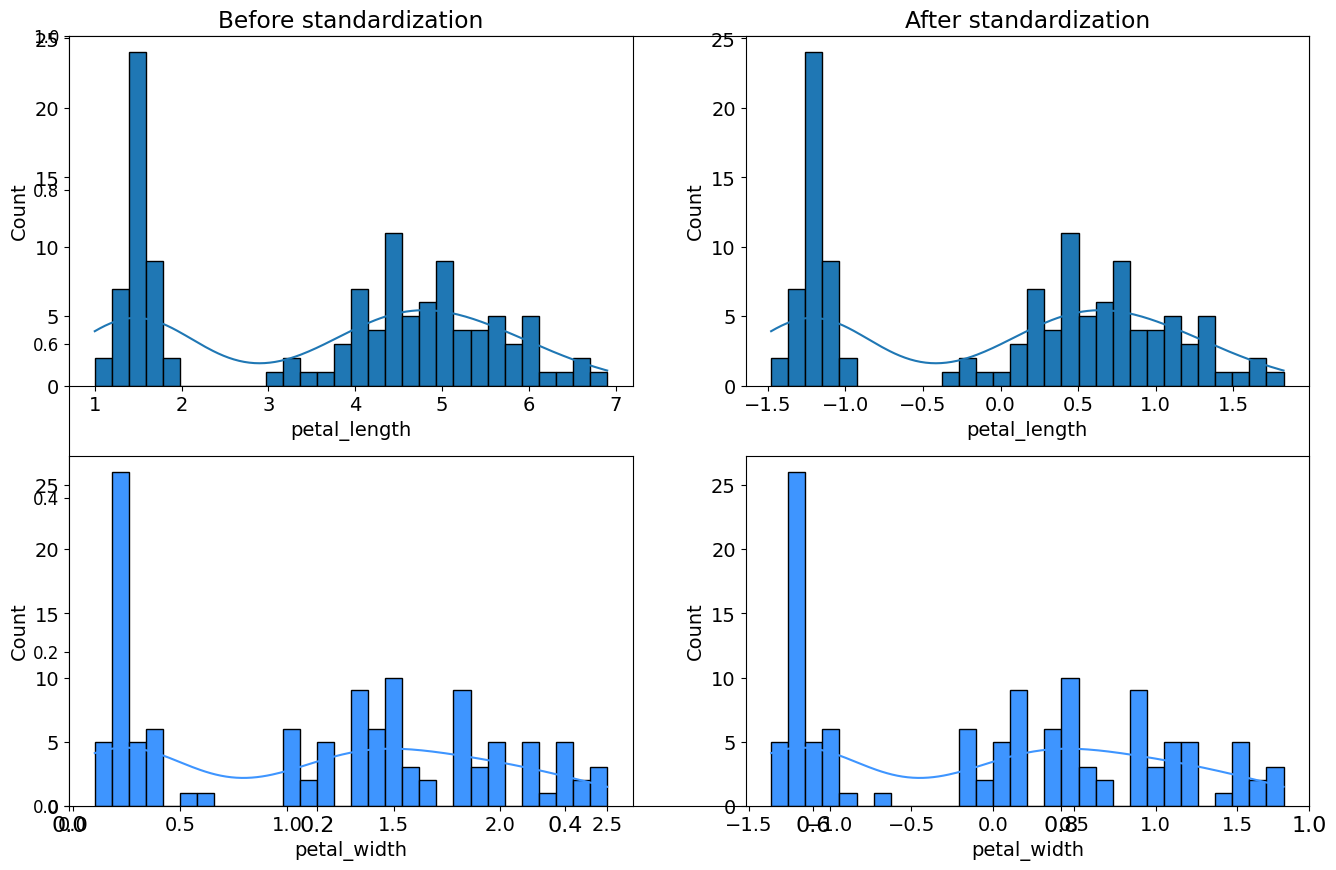

In [10]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns

nbins=30
fig = plt.figure(figsize=(16, 10))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax00=plt.subplot(gs[0,0], title="Before standardization")
fig00=sns.histplot(data=x_trainTmp,x="petal_length", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax10=plt.subplot(gs[1,0])
fig10=sns.histplot(data=x_trainTmp,x="petal_width", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="After standardization")
fig01=sns.histplot(data=x_trainSDF,x="petal_length", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax11=plt.subplot(gs[1,1])
fig11=sns.histplot(data=x_trainSDF,x="petal_width", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

<div class="rq">
La distribution renormalisée des longueurs et largeurs des iris du training set vient d'être affichée. Analysez ces résultats et comparez-les à ceux calculés avant la standardisation.
<br><b>NB.</b> Le test set a lui aussi été standardisé, avec les mêmes paramètres que le jeu d'apprentissage.
</div>

<div class="rqE">
The renormalized distribution of the iris lengths and widths of the training set has just been displayed. Analyze these results and compare them to those calculated before standardization.
<br><b>NB.</b> The test set has also been standardized, with the same parameters as the training set.
</div>

### Modèle de réseau de neurones<br>*Artificial neural network (ANN) model*

<div class="intro">

On va maintenant
- définir un modèle de réseau de neurones
- lancer son apprentissage (dit supervisé, car l'algorithme doit à apprendre à prédire à partir d'exemples annotés)
</div>

<div class="introE">

We will now

- define a neural network model
- launch its training (supervised, because the algorithm must learn to predict from labeled examples)
</div>

#### Définition du modèle<br>*Model definition*
<div class="intro">
    
On va définir le réseau de neurones. Rappelons d'abord l'architecture du réseau qu'on va optimiser ici :
    <p style="text-align: center"><img width="250px" src="DS4B-svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"/></p>

Grâce à la simplicité de `Keras`, chaque couche de neurones est définie par une *unique* ligne. 
- la première définit la couche d'entrée. Le nombre de neurones (*NE*) est passé en paramètres du modèle
- la 2ème et la 3ème sont les couches cachées, définies par le nombre de neurones qui les constituent et par leur mode d'activation
- la 4ème ligne est la couche de sortie, définie par 3 neurones et par lafonction d'activation. Cette fonction `softmax` est adaptée à la classification

Puis on indique à `Keras` de configurer le modèle (`compile`) :
- L'optimiseur est la méthode de minimisation entre ce qu'on veut faire apprendre et ce que l'algorithme restitue pendant son apprentissage
- On va minimiser l'écart entre probabilités connues (les 3 $y_k$) et probabilités prédites ($\hat{y}_k$) . C'est la fonction `loss`. Pour une classification, il est recommandé d'utiliser la fonction `categorical_crossentropy`, qui est un peu plus complexe en réalité que $y_k-\hat{y}_k$, puisque son expression est(\*) :
$$-\frac{1}{n}\sum_{k}\left(y_{k}\log\hat{y}_{k}(\boldsymbol{\theta})+(1-y_{k})\log(1-\hat{y}_{k}(\boldsymbol{\theta}))\right)^{2}$$
- on demande également au modèle de renvoyer la précision (`accuracy`) grâce à la variable `metrics`. Ça va permettre d'évaluer la capacité prédictive du modèle, puisque c'est basé sur le nombre d'identifications correctes et erronées (les vrais ou faux positifs ou négatifs)

(\*) le paramètre $\boldsymbol{\theta}$ représente l'ensemble des poids des connexions neuronales ainsi que l'ensemble des biais associé à chaque neurone 
</div>

<div class="introE">
    
We will define the neural network. Let's first recall the architecture of the network that will be optimized hereafter:
<p style="text-align: center"><img width="250px" src="DS4B-svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"/></p>

Thanks to the simplicity of `Keras`, each layer of neurons is defined by a single line.
<li> The first one defines the input layer. The number of neurons (NE) is passed as model parameters
<li> the 2nd and 3rd are the hidden layers, defined by the number of neurons that constitute them and by their activation mode
<li> the 4th line is the output layer, defined by 3 neurons and by the activation function. This `softmax` function is adapted to the classification
<br><br>

Then we tell `Keras` to configure the model (`compile`):  
<li> The optimizer is the minimization method between what we want to teach to the ANN and what the algorithm returns during its learning
<li> We will minimize the difference between known probabilities (the 3 $y_k$) and predicted probabilities ($\hat{y}_k$). This is the loss function. For a classification, it is recommended to use the `categorical_crossentropy` function, which is a bit more complex in reality than yk-yhatk, since its expression is(*) :
$$-\frac{1}{n}\sum_{k}\left(y_{k}\log\hat{y}_{k}(\boldsymbol{\theta})+(1-y_{k})\log(1-\hat{y}_{k}(\boldsymbol{\theta}))\right)^{2}$$

<br>
<li> We also ask the model to return the `accuracy` thanks to the `metrics` variable. This will allow to evaluate the predictive capacity of the model, since it is based on the number of correct and erroneous identifications (true or false positives or negatives)
<br><br>(*) the parameter $\boldsymbol{\theta}$ represents the set of weights of the neuronal connections as well as the set of biases associated to each neuron
</div>

In [11]:
def define_model(NE): #NE = nombre de neurones d'entrée
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(NE, name='iLayer'))
    model.add(keras.layers.Dense(7, activation='relu', name='hLayer1'))
    model.add(keras.layers.Dense(5, activation='relu', name='hLayer2'))
    model.add(keras.layers.Dense(3, activation='softmax', name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'categorical_crossentropy',
                  metrics   = ['accuracy'] )
    return model

#### Apprentissage supervisé du réseau de neurones<br>*Supervised learning of the ANN*

<div class="intro">

C'est maitenant qu'on lance l'apprentissage.
- on définit d'abord le modèle `ANNmodel=define_model( (2,)) `, où 2 = 2 neurones d'entrée (largeur et longueur)
- on lance son optimisation `ANNmodel.fit`. L'algorithme (l'IA) optimal ainsi que les algorithmes intermédiaires vont être sauvegardés en tant que `ANNhistory`
</div>

<div class="rq"><b>Qu'est-ce qui est sauvé au juste ?</b>
Les poids des connexions et les biais, dont l'optimisation a conduit à améliorer la reconnaissance des iris
</div>

<div class="intro">

Les principaux paramètres de `ANNmodel.fit` sont
- les caractéristiques d'entrée : `x_train`
- les classes qu'on veut prédire en fonction des caractéristiques d'entrée : `y_train`
- le nombre maximal de cycle d'apprentissage (`epochs`)
- les jeux de données qui vont permettre à chaque pas d'apprentissage (d'optimisation) d'évaluer les performances de l'algorithme sur des données qui ne servent pas à l'apprentisssage (sorte de "contrôle continu intégral et permanent") : `x_test` et le résultat attendu, `y_test`
    
</div>

<div class="introE">

Now we start the learning process.
- first we define the model `ANNmodel=define_model( (2,))` where 2 = 2 input neurons (width and length)
- we run its optimization (its training) with the command `ANNmodel.fit`. The optimal algorithm (the AI) and the intermediate algorithms will be saved as `ANNhistory`
</div>

<div class="rqE"><b>What exactly is saved?</b>
The connection weights and biases, whose optimization led to improved iris recognition
</div>

<div class="introE">

The main parameters of `ANNmodel.fit` are:
- the input features: `x_train`
- the classes we want to predict according to the input features: `y_train`
- the maximum number of learning steps (`epochs`)
- the data sets that will allow us to evaluate the performance of the algorithm on data that are not used for learning (a kind of "continuous and permanent control"): `x_test` and the expected result, `y_test`
    
</div>

In [12]:
vID.chrono_start()
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
ANNmodel=define_model( (2,)) # 2 neurones d'entrée
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 700,
                    batch_size      = 5,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

2023-12-03 15:31:27.219181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer1 (Dense)             (None, 7)                 21        
                                                                 
 hLayer2 (Dense)             (None, 5)                 40        
                                                                 
 oLayer (Dense)              (None, 3)                 18        
                                                                 
Total params: 79 (316.00 Byte)
Trainable params: 79 (316.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/700
24/24 [==============================] - 1s 14ms/step - loss: 1.2670 - accuracy: 0.3917 - val_loss: 1.3392 - val_accuracy: 0.2333
Epoch 2/700
24/24 [==============================] - 0s 3ms/step - loss: 1.1514 - accuracy: 0.4083 - val_loss: 1.2056 - val_accuracy: 0.2333
E

<div class="intro">

On va tracer l'évolution de la précision et de la fonction loss au cours des cycles d'apprentissage. On va le faire à la fois pour les données qui ont servi à l'apprentissage (*train*) et pour celles du "contrôle continu" (*test*)</div>

<div class="introE">

We will plot the evolution of the accuracy and the loss function during the learning steps. We will do this both for the data used for training and for the data of the "continuous assessment" (*test*)</div>

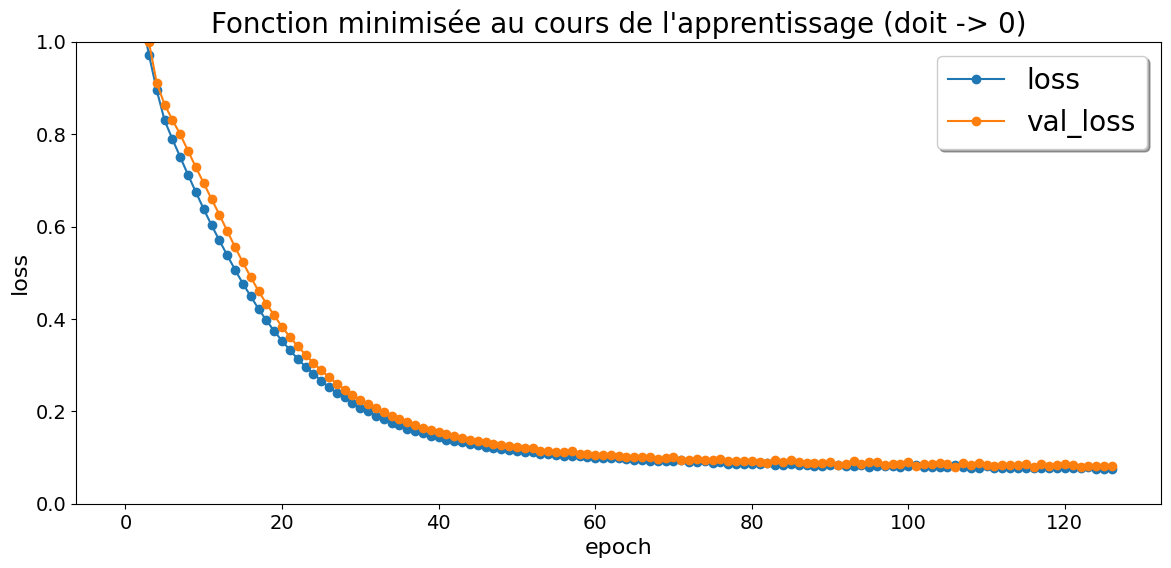

In [14]:
# c'est pratique d'utiliser un dataframe et les fonctions de tracé associées
df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
# on va d'abord tracer les courbes de la fonction qui a été minimisée au cours de l'apprentissage
figLOSS=df.plot(y=["loss","val_loss"],linestyle='-', marker='o',fontsize=14)
figLOSS.set_xlabel('epoch',fontdict={'fontsize':16})
figLOSS.set_ylabel('loss',fontdict={'fontsize':16})
figLOSS.set_ylim([0.0,1.0])
figLOSS.set_title("Fonction minimisée au cours de l'apprentissage (doit -> 0)", size=20)
figLOSS.legend(loc='upper right', shadow=True, fontsize='x-large')


<div class="rq">
<li> <span style="color:#1a6495">l'algorithme apprend de mieux en mieux à reconnaître les iris au cours des cycles d'apprentissage (courbe "loss")</span>
<li> <span style="color:#c1600b">il est aussi capable de convenablement classer les espèces qu'il ne connaît pas (c'est-à-dire qui n'ont pas été utilisées pour son apprentissage, courbe "val_loss")</span>
</div> 

<div class="rq">
<li> <span style="color:#1a6495">the algorithm learns better and better to recognize irises during the learning cycles ("loss" curve)</span>
<li> <span style="color:#c1600b">it is also able to properly classify the species that it does not know (i.e. that have not been used for its learning, "val_loss" curve)</span>
</div> 

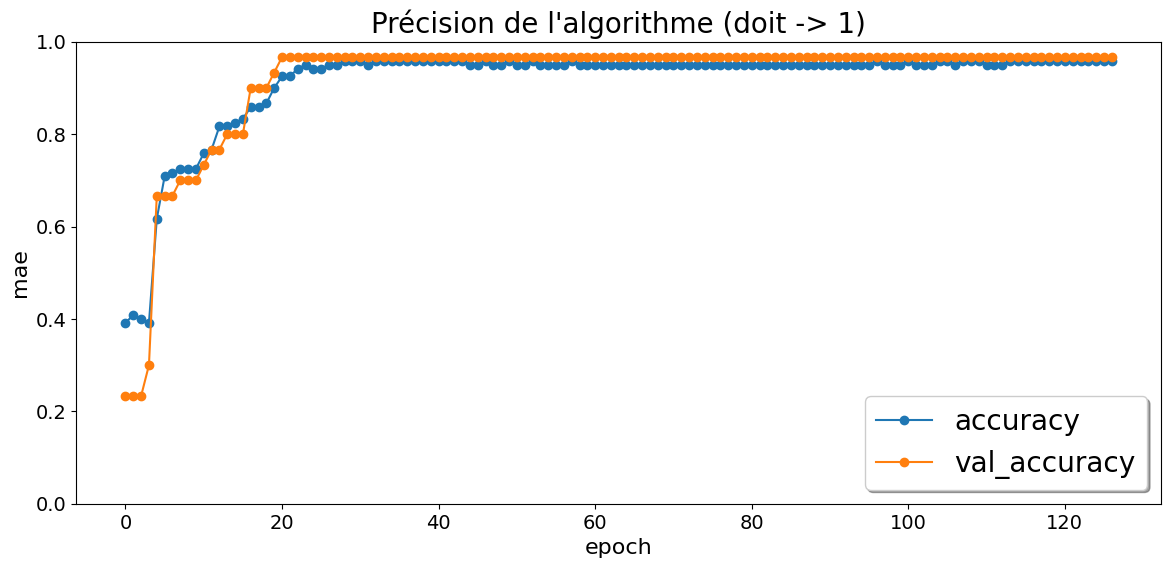

In [15]:
# création d'un nouveau dataFrame qui permet de juger de l'évolution de la précision de l'algortihme
figACC=df.plot(y=["accuracy","val_accuracy"],linestyle='-', marker='o',fontsize=14)
figACC.set_xlabel('epoch',fontdict={'fontsize':16})
figACC.set_ylabel('mae',fontdict={'fontsize':16})
figACC.set_ylim([0.0,1.0])
figACC.set_title("Précision de l'algorithme (doit -> 1)", size=20)
figACC.legend(loc='lower right', shadow=True, fontsize='x-large')

<div class="rq">
<li> <span style="color:#1a6495">on a confirmation que l'algorithme apprend de mieux en mieux à <b>classer</b> les iris au cours des cycles d'apprentissage (courbe "accuracy"). Il ne commet quasiment aucune erreur en fin d'apprentissage puisque ce paramètre tend vers 1.</span>
<li> <span style="color:#c1600b">la courbe "val_accuracy" montre que l'algorithme commet également peu d'erreurs d'identification des espèces qui n'ont pas servi à son apprentissage</span>
</div> 

<div class="rq">
<li> <span style="color:#1a6495">we have confirmation that the algorithm learns better and better to <b>classify</b> irises during the learning cycles ("accuracy" curve). It commits almost no error at the end of the learning process since this parameter tends towards 1.</span>
<li> <span style="color:#c1600b">
the "val_accuracy" curve shows that the algorithm also makes few errors in identifying species that were not used in its training</span>
</div> 

### Évaluation de la précision du réseau de neurones après apprentissage<br>*Assessment of the accuracy of the ANN*

#### Évaluation numérique globale<br>*Global assessment*

<div class="intro">

On introduit ici la fonction `evaluate` de `Keras`. On lui fournit un jeu de données d'entrée et le résultat attendu. Elle va se servir du modèle optimisé (car on fait appel à `ANNmodel.evaluate`) afin de renvoyer les valeurs des erreurs "loss" et "accuracy"</div>

<div class="introE">

We introduce here the `evaluate` function of `Keras`. We give it an input data set and the expected result. It will use the optimized model (because we use `ANNmodel.evaluate`) to return the values of the errors "loss" and "accuracy".</div>

In [16]:
evalANN_on_TrainSet = ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {evalANN_on_TrainSet[0]:5.4f}{color.OFF}")
print(f"{color.GREEN}x_train / accuracy  : {evalANN_on_TrainSet[1]:5.4f}{color.OFF}")
print()
evalANN_on_TestSet = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_test / loss      : {evalANN_on_TestSet[0]:5.4f}{color.OFF}")
print(f"{color.BLUE}x_test / accuracy  : {evalANN_on_TestSet[1]:5.4f}{color.OFF}")

x_train / loss      : 0.0747
x_train / accuracy  : 0.9583

x_test / loss      : 0.0807
x_test / accuracy  : 0.9667


#### Utilisation de l'algorithme ANN comme prédicteur<br>*The trained ANN used as for prediction*
<div class="app">

Un botaniste a découvert au fond de son jardin un Iris de la famille <i>setosa</i>, dont les pétales sont de largeur 0.25 cm.
<ol>
    <li> quelle est la longueur de pétale peut-on prédire, à partir de la base de données "iris"?
    <li> la longueur mesurée est en fait de 1.45 cm. Quelle est l'erreur quadratique commise par le modèle statistique ?
</ol> 
<i>On avait posé question dans la deuxième partie ("statistiques et régression")</i>
</div>
<br>
<div class="rq"><b>Peut-on répondre à ces questions à l'aide du réseau de neurones optimisé?</b>
<br>Non. Ce modèle statistique n'est pas conçu pour ça. <br><br>On va en revanche pouvoir répondre à la question suivante:</div>
<br>

<div class="app">

À l'occasion d'une randonnée, vous venez de découvrir un Iris, dont les pétales sont de dimension moyenne 1.45 cm x 0.25 cm. Vous êtes nul en botanique, mais grâce aux petites applications d'IA "maison" que vous avez sauvées sur votre smartphone, vous allez en déduire de quelle espèce il s'agit.
</div>

<div class="intro">

On va simplement utiliser la fonction `predict`, qui va renvoyer trois valeurs de probabilité (dans l'ordre *setosa*, *versicolor*, *virginica*) :</div>

<div class="appE">

A botanist discovered at the bottom of his garden an iris of the setosa family, whose petals are 0.25 cm wide.

<ol>
    <li> what is the length of the petal that can be predicted, based on the "iris" database?
    <li> the measured length is in fact 1.45 cm. What is the squared error committed by the statistical model?
</ol> 
<i>We asked this question in the second part ("statistics and regression")</i>
</div>
<br>
<div class="rqE"><b>Can these questions be answered with the optimized neural network?</b>
<br>No. This statistical model is not designed for that.
<br><br>On the other hand, we can answer the following question:
</div>
<br>
<div class="appE">

On a hike, you just discovered an Iris, whose petals are of average size 1.45 cm x 0.25 cm. You're a botanist, but thanks to the little "home-made" AI applications you've saved on your smartphone, you're going to deduce which species it is.
</div>

<div class="introE">

We will simply use the `predict` function, which will return three probability values (in the order *setosa*, *versicolor*, *virginica*):
 :</div>

In [17]:
# attention : les données sont entrées dans l'ordre longueur puis largeur, sous forme de tableau au format numpy
sample = [1.45, 0.25]
print(f"probabilités: {ANNmodel.predict([sample])}")

1/1 [==============================] - 0s 112ms/step
probabilités: [[0.00087976 0.17106909 0.82805127]]


<div class="rq">L'algorithme n'a pas de doute sur le fait que c'est un iris de type <i>virginica</i>. <b>Êtes-vous d'accord?</b> (on suggère de se reporter à la figure reliant longueur et largeur, reportée dans l'introduction)<br>
<br>
En fait, on a oublié une étape préliminaire, la <b><span style="color:red">standardisation des données...</span></b>
<br>L'algorithme a été optimisé sur la base de données d'entrées standardisées. Toute nouvelle donnée qui lui est soumise doit elle aussi être standardisée. On va pour cela à nouveau utiliser la commande <code>scaler.transform()</code> de la bibliothèque <code>scikit learn</code>
</div>

<div class="rqE">
    
The algorithm has no doubt that it is a *virginica* iris. **Do you agree?** (we suggest to refer to the figure linking length and width, reported in the introduction)

In fact, we forgot a preliminary step, the <b><span style="color:red">standardization of the data...</span></b>
The algorithm has been optimized on the basis of standardized input data. Any new data submitted to it must also be standardized. To do this, we will again use the `scaler.transform()` command of the `scikit learn` library
</div>

In [18]:
sample = [1.45, 0.25]
print(f"échantillon avant la standardisation : {sample}")
print(f"probabilités avant standardisation: {ANNmodel.predict([sample])}")
print()

sample = scaler.transform([sample])
print(f"échantillon après la standardisation : {sample}")
print(f"probabilités après standardisation: {ANNmodel.predict([sample])}")

échantillon avant la standardisation : [1.45, 0.25]
1/1 [==============================] - 0s 52ms/step
probabilités avant standardisation: [[0.00087976 0.17106909 0.82805127]]

échantillon après la standardisation : [[-1.22615053 -1.16506977]]
1/1 [==============================] - 0s 72ms/step
probabilités après standardisation: [[9.99629021e-01 3.56012722e-04 1.49476255e-05]]


<div class="rq">Ça change tout. Et c'est maintenant une prédiction correcte (<i>en principe... sauf si l'algorithme a par malchance mal appris sa leçon. il n'y a aucune assurance avec un si petit jeu de données d'apprentissage</i>).</div>

<div class="rqE">

This changes everything. And it is now a correct prediction (*in principle... unless the algorithm has unluckily learned its lesson wrong. There is no guarantee with such a small training data set*).</div>

<div class="intro">

On va utiliser dans le paragraphe suivant les fonctions `argmax` de `numpy `, ainsi que la fonction `unique` de `pandas`. On va regarder leur comportement ici :
</div>

<div class="introE">

In the following paragraph we will use the `argmax` function of `numpy`, and the `unique` function of `pandas`. We will look at their behavior here :
</div>

In [19]:
probas = ANNmodel.predict([sample])
print("probas: ", probas)
print("argmax(probas): ",np.argmax(probas)) #va renvoyer l'indice de l'élément qui a la valeur la plus élevée de toute la liste

1/1 [==============================] - 0s 29ms/step
probas:  [[9.99629021e-01 3.56012722e-04 1.49476255e-05]]
argmax(probas):  0


<div class="rq">

`unique`, dont on montre l'utilité ci-dessous, a aussi été utilisé pour fabriquer les dernières colonnes (de catégorisation) de la base de données utilisée dans ce notebook
</div>
<div class="rqE">

`unique`, whose usefulness is shown below, was also used to make the last columns (categorisationµ) of the database used in this notebook
</div>

In [19]:
usp = dfi['species'].unique() # usp = Unique SPecies
print(usp)

['setosa' 'versicolor' 'virginica']


<div class="rq">

C'est-à-dire que l'élement 0 de `usp` contient le nom de l'espèce

Donc si on utilise la résultat de `argmax(probas)` en argument de `usp`, ça va directement renvoyer le nom de l'espèce plutôt qu'une liste de probabilités :
</div>
<div class="rqE">

That is, element 0 of `usp` contains the name of the species

So if we use the result of `argmax(probas)` as an argument to `usp`, it will directly return the name of the species rather than a list of probabilities:
</div>

In [ ]:
print("l'iris observé est de type :",usp[np.argmax(probas)])

#### Comportement du modèle vis-à-vis de chaque espèce d'iris<br>*Behavior of the model towards each iris species*

<div class="intro">

La partie ci-dessous est un peu longue, mais pas compliquée. L'objectif est d'afficher les probailités pour chacun des échantillons du jeu d'apprentissage (train). Elles sont converties en espèce grâce à `argmax` et à la liste `usp`. On peut ainsi directement comparer avec les espèces réellement observées. La fin du script permet de comptabiliser les erreurs.

Puis il est fait de même pour les échantillons du jeu de test.</div>

<div class="introE">

The part below is a bit long, but not complicated. The goal is to display the probabilities for each sample of the training set (train). They are converted into species thanks to `argmax` and the `usp` list, so that we can directly compare them with the species actually observed. At the end of the script, the errors are counted.

Then the same is done for the samples of the test set.</div>

In [21]:
usp = dfi['species'].unique()
print(f"{color.BOLD}{color.GREEN}Catégories uniques d'iris :{color.OFF} {usp}")
# cette correspondance élément 0 <-> setosa ; élément 1 <-> versicolor ; élément 2 <-> virginica
# va servir à transformer les probabilités les plus élevées en espèce d'iris

y_train_hat=ANNmodel.predict(x_train)
ytr_hD = pd.DataFrame(y_train_hat, columns=usp, index=y_train.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tr_hat = usp[np.argmax(y_train_hat,axis=1)]
# on ajoute cette colonne au dataframe ytr_hD
ytr_hD['Espèce prédite'] = pd.DataFrame(iris_tr_hat, index=y_train.index)
ytr_hD['Espèce observée'] = pd.DataFrame(y_train_species, index=y_train.index)
print(f"{color.BOLD}{color.BLUE}Training Set{color.OFF}. Comparaison entre espèce prédite et espèce observée")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytr_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: format standard 
diff_Pred_Obs=np.where(ytr_hD['Espèce prédite'] == ytr_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

print()
y_test_hat=ANNmodel.predict(x_test)
ytt_hD = pd.DataFrame(y_test_hat, columns=usp, index=y_test.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tt_hat = usp[np.argmax(y_test_hat,axis=1)]
# on ajoute cette colonne au dataframe ytt_hD
ytt_hD['Espèce prédite'] = pd.DataFrame(iris_tt_hat, index=y_test.index)
ytt_hD['Espèce observée'] = pd.DataFrame(y_test_species, index=y_test.index)
print(f"{color.BOLD}{color.RED}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée.")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytt_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: 
diff_Pred_Obs=np.where(ytt_hD['Espèce prédite'] == ytt_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

Catégories uniques d'iris : ['setosa' 'versicolor' 'virginica']
4/4 [==============================] - 0s 3ms/step
Training Set. Comparaison entre espèce prédite et espèce observée


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
74,0.00,0.99,0.00,versicolor,versicolor
83,0.00,0.46,0.54,virginica,versicolor
147,0.00,0.00,1.00,virginica,virginica
129,0.00,0.09,0.91,virginica,virginica
78,0.00,0.95,0.05,versicolor,versicolor
9,1.00,0.00,0.00,setosa,setosa
93,0.01,0.99,0.00,versicolor,versicolor
32,1.00,0.00,0.00,setosa,setosa
115,0.00,0.00,1.00,virginica,virginica
66,0.00,0.95,0.05,versicolor,versicolor


Nombre d'erreurs : 5

1/1 [==============================] - 0s 30ms/step
Test Set. Comparaison entre espèce prédite et espèce observée.


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
0,1.00,0.00,0.00,setosa,setosa
4,1.00,0.00,0.00,setosa,setosa
13,1.00,0.00,0.00,setosa,setosa
16,1.00,0.00,0.00,setosa,setosa
24,1.00,0.00,0.00,setosa,setosa
25,1.00,0.00,0.00,setosa,setosa
28,1.00,0.00,0.00,setosa,setosa
29,1.00,0.00,0.00,setosa,setosa
31,1.00,0.00,0.00,setosa,setosa
33,1.00,0.00,0.00,setosa,setosa


Nombre d'erreurs : 2


<div class="rq">Ce serait assez fastidieux de procéder à une analyse ligne par ligne si la base de données était constituée de milliers d'échantillons. Le module <code>scikit learn</code> permet de visualiser de façon graphique les succcès et erreurs d'un algorithme. Il s'agit de <b style="color:red">matrices de confusion</b>. C'est l'objet du paragraphe suivant.</div>

<div class="rqE">
    
It would be quite tedious to do this analysis line by line if the database consisted of thousands of samples. The `scikit learn` module allows to visualize in a graphical way the successes and errors of an algorithm. These are <b style="color:red">confusion matrices</b>. This is the subject of the following paragraph
</div>

#### Bilan de la performance du modèle prédictif sous forme de matrice de confusion<br>*Assessment of the accuracy of the model by a confusion matrix*

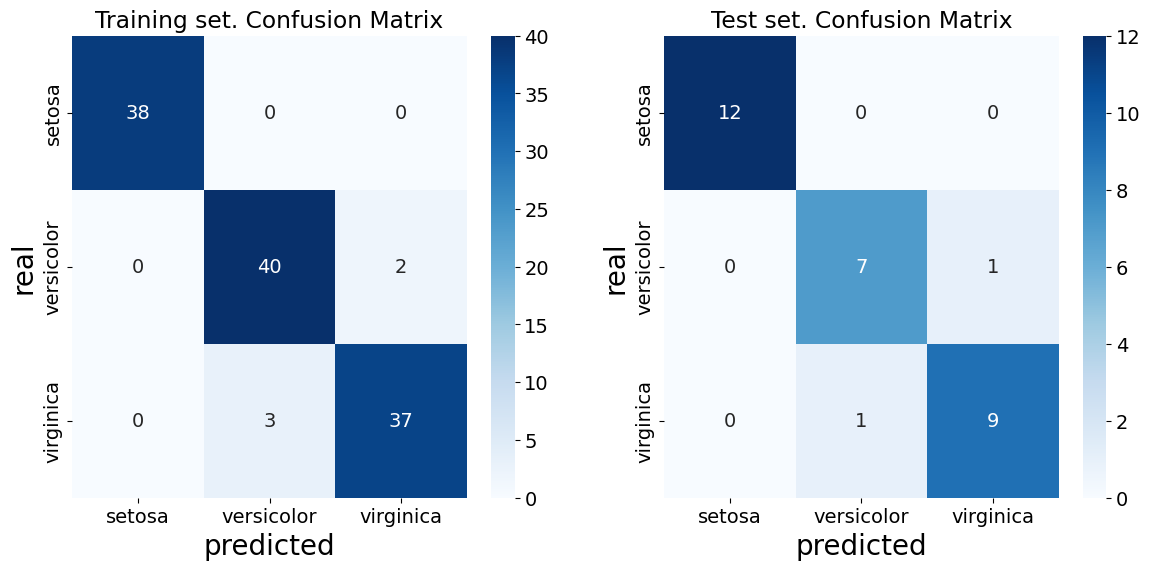

In [22]:
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix
# cm_labels = dfi['species'].unique()
# cm_tr = confusion_matrix(np.argmax(y_train.to_numpy(),axis=1), np.argmax(y_train_hat,axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=cm_labels)
# disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
# plt.title('Training set. Matrice de confusion')
# plt.show()
# cm_tt = confusion_matrix(np.argmax(y_test.to_numpy(),axis=1), np.argmax(y_test_hat,axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_tt, display_labels=cm_labels)
# disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
# plt.title('Test set. Matrice de confusion')
# plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_labels = dfi['species'].unique()
cm_tr = confusion_matrix(np.argmax(y_train.to_numpy(),axis=1), np.argmax(y_train_hat,axis=1))
cm_tt = confusion_matrix(np.argmax(y_test.to_numpy(),axis=1), np.argmax(y_test_hat,axis=1))

fig=plt.figure()
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0], title="Training set. Confusion Matrix")
sns.heatmap(pd.DataFrame(cm_tr, columns=cm_labels, index=cm_labels), ax=ax00, cmap=plt.cm.Blues, annot = True)
ax00.set_xlabel("predicted", fontsize = 20)
ax00.set_ylabel("real", fontsize = 20)

ax01=fig.add_subplot(gs[0, 1], title="Test set. Confusion Matrix")
sns.heatmap(pd.DataFrame(cm_tt, columns=cm_labels, index=cm_labels), ax=ax01, cmap=plt.cm.Blues, annot = True)
ax01.set_xlabel("predicted", fontsize = 20)
ax01.set_ylabel("real", fontsize = 20)
plt.show()

fig.savefig("./DS4B-svg/Iris3-ConfusionMatrix-petals.png")

<div class="rq">
On rappelle à quoi ressemble la corrélation entre longueurs et largeurs de pétales, et l'apparente classification par espèce qui nous a amenés à bâtir une IA classifiant les iris à partir de la dimension de leurs pétales :
    <p style="text-align: center"><img width="500px" src="DS4B-svg/jointplot_petals.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
<li> il n'est pas surprenant que l'algorithme ne se trompe jamais dans l'identification des iris <i>setosa</i>, qui sont nettement plus petits que les autres
<li> les seules erreurs sont une confusion entre <i>versicolor</i> et <i>virginica</i>
<li> si on prend le temps d'analyser les échantillons concernés, on s'aperçoit que les erreurs sont le plus ouvent commises pour des espèces dont les dimension de pétales sont environ 5 x 1.9 cm, c'est-à-dire dans la zone de recouvrement entre les deux espèces dans la figure ci-dessus. <b> Il n'y a donc pas de miracle, sur la base des données qu'on lui a fournies, l'IA ne peut pas faire mieux qu'un être humain'.</b>
</div>

<div class="rqE">
We recall what the correlation between length and width of petals looks like, and the apparent classification by species that led us to build an AI classifying irises from the size of their petals:
    <p style="text-align: center"><img width="500px" src="DS4B-svg/jointplot_petals.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
<li> it is not surprising that the algorithm never makes a mistake in identifying <i>setosa</i> irises, which are much smaller than the others
<li> the only errors are a confusion between <i>versicolor</i> and <i>virginica</i>
<li> if we take the time to analyze the samples concerned, we see that the errors are most often made for species whose petal size is about 5 x 1.9 cm, that is to say in the overlap area between the two species in the figure above. <b>So there is no miracle, on the basis of the data provided to it, the AI cannot do better than a human being.</b>
</div>

### Bilan de la troisième partie<br>*Review of this third part*
<div class='rq'>

La figure ci-dessous résume comment est en général développé et optimisé un algorithme d'apprentissage automatique. C'est ce "workflow" que nous venons d'appliquer.  
<p style="text-align: center"><img width="750px" src="DS4B-svg/BilanML-Classification.svg" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
 
On a développé ici un algorithme de reconnaissance basé sur deux caractéristiques, les longueur et largeur des pétales d'iris. C'est un assez gros effort algorithmique alors qu'il suffit finalement d'exploiter le graphique reliant longueur et largeur, avec le code couleur qui permet de classer les espèces en fonction de cela. En résumé, les petits iris sont des *setosa*, les grands sont des *virginica* et les moyens sont des *versicolor*. <b>Dit comme ça, ça semble facile, mais ce sont des compétences (mesure, tracé de graphique, exploitation d'un graphique) qu'on a nous-mêmes dévelopé quelque part entre fin de l'école élémentaire et le collège</b>. <span style="color:red">On a donc pour le moment une IA niveau "*entrée en sixième*".</span> 

L'exercice qui est proposé en complément vise à développer un algorithme capable d'établir une corrélation plus complexe, en prenant simultanément en compte les longueurs et largeurs des pétales et des sépales. Et on va voir que ça permet effectivement de diminuer l'erreur commise. On conviendra que ça devient plus compliqué pour nos cerveaux de rechercher si les corrélations croisées, reportées dans la figure ci-dessous, permettent une meilleure classification. C'est pour ce type de tâche, au-delà de corrélations simples, que l'utilisation de ces algorithmes prend tout son sens. 
<p style="text-align: center"><img width="850px" src="DS4B-svg/pairplot_Iris.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>

</div>

<div class='rqE'>

The figure below summarizes how a machine learning algorithm is usually developed and optimized. It is this workflow that we have just applied.  
<p style="text-align: center"><img width="750px" src="DS4B-svg/BilanML-Classification-English.svg" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
 
We have developed here a recognition algorithm based on two characteristics, the length and width of the iris petals. It is a rather big algorithmic effort when it is finally enough to exploit the graph linking length and width, with the color code that allows to classify the species according to that. In summary, small irises are *setosa*, large ones are *virginica* and medium ones are *versicolor*. **Said like that, it seems easy, but these are skills (measurement, graphing, exploitation of a graph) that we have developed ourselves somewhere between the end of elementary school and college**. <span style="color:red">We have therefore for the moment a "junior high school entrance" level of AI.</span>

The exercise which is proposed in complement aims at developing an algorithm able to establish a more complex correlation, by simultaneously taking into account the lengths and widths of the petals and the sepals. And we will see that it allows to decrease the error. We will agree that it becomes more complicated for our brains to search if the cross-correlations, reported in the figure below, allow a better classification. It is for this type of task, beyond simple correlations, that the use of these algorithms makes sense.
<p style="text-align: center"><img width="850px" src="DS4B-svg/pairplot_Iris.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>

</div>

### Chapitre suivant : la compression des données<br>*Next chapter: data compression*

<div class="intro">
    
Ce sujet offre aussi une opportunité d'illustrer comment mettre en oeuvre une **analyse en composante principale** (ACP = PCA, Principal Component Analysis), et ce que ça apporte à l'analyse. Elle est utilisée pour extraire et visualiser les informations importantes contenues dans une table de données qui contient de nombreuses variables (4 dans le cas des iris = largeurs et longueurs des pétales et sépales). L'ACP synthétise cette information en seulement quelques nouvelles variables appelées composantes principales.
    
C'est l'objet du [sujet suivant](./DS4B-IrisPCA.ipynb) (en anglais).

Il est d'abord recommandé de faire [l'exercice associé à ce chapitre](./DS4B-Exercices/DS4B-Iris3-Exercice.ipynb).

</div>

<div class="introE">
    
This topic also offers an opportunity to illustrate how to implement a Principal Component Analysis (PCA), and what it brings to the analysis. It is used to extract and visualize important information from a data table that contains many variables (4 in the case of irises = widths and lengths of petals and sepals). PCA synthesizes this information into only a few new variables called principal components.

This is the subject of the [following topic](./DS4B-IrisPCA.ipynb).

It is first recommended to do the [exercise associated with this chapter](./DS4B-Exercices/DS4B-Iris3-Exercice.ipynb) (in French).
</div>

### Évaluation formative après la vidéo


Voir les quizz (uniquement pour les étudiants d'UT3, cf Moodle)

In [ ]:
vID.end(cwd0)